In [1]:
import matplotlib.pyplot as plt
import xarray as xr

from skdownscale.pointwise_models import AnalogRegression, PureAnalog

In [2]:
# open a small dataset for training
training_time_slice = slice('1980', '2001')
data = xr.open_datatree(
    's3://carbonplan/share/scikit-downscale/test-data.zarr',
    engine='zarr',
    chunks={},
    storage_options={'anon': True, 'endpoint_url': 'https://rice1.osn.mghpcc.org'},
)
training = data['training'].to_dataset().sel(time=training_time_slice)
training

<xarray.Dataset> Size: 2MB
Dimensions:      (point: 5, time: 8036)
Coordinates:
  * time         (time) datetime64[ns] 64kB 1980-01-01T11:30:00 ... 2001-12-3...
    lat          (point) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
    lon          (point) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: point
Data variables: (12/15)
    DIV          (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_ACC_C   (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_ACC_NC  (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_TOT     (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PSFC         (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    QVAPOR       (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    ...           ...
    T2min        (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    T_MEAN       (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    T_RANGE      (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    U            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    V            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    W            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
Attributes:
    NCO:                        "4.5.5"
    history:                    Wed Mar  1 13:48:35 2017: ncatted -a calendar...
    history_of_appended_files:  Wed Feb  8 14:15:52 2017: Appended file wrf_d...
    nco_openmp_thread_number:   1

In [3]:
# open a small dataset of observations (targets)
targets = data['targets'].to_dataset().sel(time=training_time_slice)
targets

<xarray.Dataset> Size: 707kB
Dimensions:  (time: 8036, point: 5)
Coordinates:
  * time     (time) datetime64[ns] 64kB 1980-01-01 1980-01-02 ... 2001-12-31
    lat      (point) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    lon      (point) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: point
Data variables:
    Prec     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    Tmax     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    Tmin     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    wind     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    CDO:                       Climate Data Operators version 1.6.4 (http://c...
    Conventions:               CF-1.4
    NCO:                       4.4.5
    history:                   Fri Oct 10 17:54:37 2014: cdo ifthenelse /Volu...
    nco_openmp_thread_number:  1

In [4]:
# extract 1 point of training data for precipitation and temperature
X_temp = training.isel(point=0).to_dataframe()[['T2max']] - 273.13
X_pcp = training.isel(point=0).to_dataframe()[['PREC_TOT']] * 24
display(X_temp.head(), X_pcp.head())

,T2max
time,
1980-01-01 11:30:00,7.249939
1980-01-02 11:30:00,6.025726
1980-01-03 11:30:00,4.645691
1980-01-04 11:30:00,3.706940
1980-01-05 11:30:00,1.753815


,PREC_TOT
time,
1980-01-01 11:30:00,9.921292
1980-01-02 11:30:00,5.249543
1980-01-03 11:30:00,1.668468
1980-01-04 11:30:00,0.005625
1980-01-05 11:30:00,0.222037


In [5]:
# extract 1 point of target data for precipitation and temperature
y_temp = targets.isel(point=0).to_dataframe()[['Tmax']]
y_pcp = targets.isel(point=0).to_dataframe()[['Prec']]
display(y_temp.head(), y_pcp.head())

,Tmax
time,
1980-01-01,7.24
1980-01-02,7.16
1980-01-03,6.53
1980-01-04,4.46
1980-01-05,1.78


,Prec
time,
1980-01-01,16.352564
1980-01-02,5.251305
1980-01-03,12.204033
1980-01-04,4.043505
1980-01-05,3.045757


/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/pyth

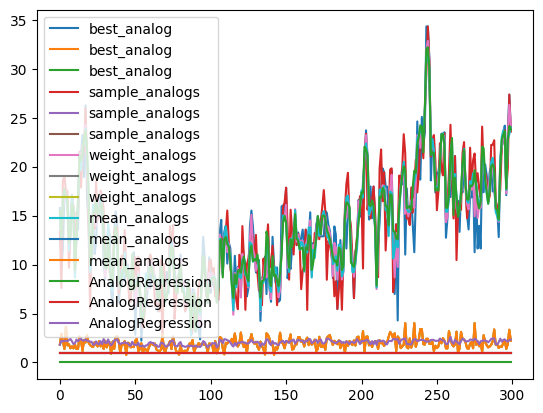

In [10]:
# Fit/predict using the PureAnalog class
for kind in ['best_analog', 'sample_analogs', 'weight_analogs', 'mean_analogs']:
    pure_analog = PureAnalog(kind=kind, n_analogs=10)
    pure_analog.fit(X_temp[:1000], y_temp[:1000])
    out = pure_analog.predict(X_temp[1000:])

    plt.plot(out[:300], label=kind)

# Fit/predict using the AnalogRegression class
analog_reg = AnalogRegression(n_analogs=100)
analog_reg.fit(X_temp[:1000], y_temp[:1000])
out = analog_reg.predict(X_temp[1000:])
plt.plot(out[:300], label='AnalogRegression')
plt.legend()
plt.show()